In [1]:
!pip install -q transformers datasets peft accelerate evaluate sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import re
import gc
import torch
import gdown
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from peft import LoraConfig, get_peft_model, TaskType
from datasets import Dataset

In [3]:
gdown.download("https://drive.google.com/uc?id=1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW", "train_data.csv", quiet =False)

Downloading...
From (original): https://drive.google.com/uc?id=1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW
From (redirected): https://drive.google.com/uc?id=1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW&confirm=t&uuid=54012b42-ec9d-4a85-8086-8fbb1f14a478
To: /kaggle/working/train_data.csv
100%|██████████| 635M/635M [00:04<00:00, 128MB/s]  


'train_data.csv'

In [4]:
df_train =pd.read_csv("train_data.csv", low_memory =False)

In [5]:
def clean_txt(t):
    if not isinstance(t, str):
        return ""
    t =t.lower()
    t =re.sub(r"<.*?>", " ", t)
    t =re.sub(r"http\S+|www\S+|https\S+", "", t, flags =re.MULTILINE)
    t =re.sub(r"(.)\1{2,}", r"\1\1", t)
    t =re.sub(r"[^a-z0-9\s\!\?\.\']", " ", t)
    t =re.sub(r"\s+", " ", t).strip()
    return t

In [ ]:
df_train['summary'] =df_train['summary'].fillna("")
df_train['reviewText'] =df_train['reviewText'].fillna("")
df_train['full_txt'] =df_train['summary'] + " . " + df_train['reviewText']


<h2 style="direction:rtl; text-align:right; font-family:'Vazir', 'Tahoma', sans-serif; margin-top:15px; margin-bottom:10px;">نمونه گیری</h2>
<p style="direction:rtl; text-align:justify; font-family:'Vazir', 'Tahoma', sans-serif; margin-bottom:12px;">
آموزش یک مدل ترنسفورمر غول پیکر روی بیش از 800 هزار سطر داده نیازمند زمان و منابع سخت افزاری عظیمی است. 200 هزار سطر را به صورت کاملاً تصادفی اما با حفظ دقیقِ توزیع کلاس ها (Stratified) جدا کردیم. این کار باعث می شود مدل توزیع واقعی نظرات آمازون را بدون نیاز به هدر دادن ده ها ساعت زمان پردازش، به درستی یاد بگیرد.
</p>


In [ ]:
df_s, _ =train_test_split(df_train, train_size =200000, stratify =df_train['overall'], random_state =42)
df_s['clean_txt'] =df_s['full_txt'].apply(clean_txt)

In [7]:
y_lbl =df_s['overall'] -1
x_tr, x_val, y_tr, y_val =train_test_split(df_s['clean_txt'], y_lbl, test_size =0.1, random_state =42, stratify =y_lbl)

del df_train
del df_s
gc.collect()

180

<h2 style="direction:rtl; text-align:right; font-family:'Vazir', 'Tahoma', sans-serif; margin-top:15px; margin-bottom:10px;">توکنایزر</h2>
<p style="direction:rtl; text-align:justify; font-family:'Vazir', 'Tahoma', sans-serif; margin-bottom:12px;">
در این فاز از مدل قدرتمند مایکروسافت (DeBERTa-v3) استفاده شده است که به دلیل مکانیزم توجهِ جداسازی شده (Disentangled Attention)، درک بسیار بهتری از موقعیت کلمات در جمله دارد. طول کلمات روی 256 تنظیم شده است تا مدل بتواند فراتر از جملات ابتدایی، به عمق نظرات طولانی کاربران نیز نفوذ کند.
</p>


In [8]:
tk =AutoTokenizer.from_pretrained("microsoft/deberta-v3-small")
def tok_func(x):
    return tk(x["text"], padding ="max_length", truncation =True, max_length =256)
tr_ds =Dataset.from_dict({"text": x_tr.tolist(), "label": y_tr.tolist()}).map(tok_func, batched =True)
val_ds =Dataset.from_dict({"text": x_val.tolist(), "label": y_val.tolist()}).map(tok_func, batched =True)

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Map:   0%|          | 0/180000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

<h2 style="direction:rtl; text-align:right; font-family:'Vazir', 'Tahoma', sans-serif; margin-top:15px; margin-bottom:10px;">به کار گیری تکنیک LoRA</h2>
<p style="direction:rtl; text-align:justify; font-family:'Vazir', 'Tahoma', sans-serif; margin-bottom:12px;">
به جای باز گذاشتن تمام 66 میلیون پارامتر مدل که منجر به خطای کمبود حافظه (OOM) می شود، از تکنیک Low-Rank Adaptation استفاده کردیم. با این روش، بدنه اصلی مدل کاملاً فریز شده و تنها ماتریس های بسیار کوچکی (با رتبه 8) در کنار لایه ها آموزش می بینند.
</p>


In [9]:
mod =AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-small", num_labels =5)
lc =LoraConfig(task_type =TaskType.SEQ_CLS, r =8, lora_alpha =16, lora_dropout =0.1)
mod =get_peft_model(mod, lc)

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/102 [00:00<?, ?it/s]

DebertaV2ForSequenceClassification LOAD REPORT from: microsoft/deberta-v3-small
Key                                     | Status     | 
----------------------------------------+------------+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED | 
mask_predictions.dense.weight           | UNEXPECTED | 
mask_predictions.classifier.weight      | UNEXPECTED | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED | 
mask_predictions.LayerNorm.bias         | UNEXPECTED | 
lm_predictions.lm_head.bias             | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED | 
mask_predictions.LayerNorm.weight       | UNEXPECTED | 
mask_predictions.dense.bias             | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED | 
mask_predictions.classifier.bias        | UNEXPECTED | 
pooler.dense.bias                       | MISSING    | 
classifier.bias                         | MISSING    | 
pooler.dense.weight                     | MISSING    | 
classifier.weight       

model.safetensors:   0%|          | 0.00/286M [00:00<?, ?B/s]

In [10]:
def comp_met(p):
    pr =np.argmax(p.predictions, axis =1)
    f1 =f1_score(p.label_ids, pr, average ='micro')
    return {"f1_micro": f1}

In [11]:
args =TrainingArguments(
    output_dir ="/kaggle/working/res",
    eval_strategy ="epoch",
    save_strategy ="epoch",
    learning_rate =5e-4,
    per_device_train_batch_size =8,
    per_device_eval_batch_size =8,
    gradient_accumulation_steps =4,
    num_train_epochs =10,
    lr_scheduler_type ="cosine",
    load_best_model_at_end =True,
    metric_for_best_model ="f1_micro",
    report_to ="none"
)

In [12]:
trn =Trainer(
    model =mod,
    args =args,
    train_dataset =tr_ds,
    eval_dataset =val_ds,
    compute_metrics =comp_met,
    callbacks =[EarlyStoppingCallback(early_stopping_patience =2)]
)

In [13]:
trn.train()

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Micro
1,5.033565,1.209227,0.756400
2,4.851791,1.186522,0.764450
3,4.651959,1.155932,0.767800
4,4.563778,1.160726,0.767750
5,4.439823,1.150574,0.767850
6,4.346208,1.144714,0.774000
7,4.284272,1.153180,0.772750
8,4.213371,1.147701,0.773750


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=22504, training_loss=4.605193723404996, metrics={'train_runtime': 13814.8571, 'train_samples_per_second': 130.295, 'train_steps_per_second': 2.036, 'total_flos': 9.571968073728e+16, 'train_loss': 4.605193723404996, 'epoch': 8.0})

In [14]:
hist =trn.state.log_history
tr_loss =[x['loss'] for x in hist if 'loss' in x]
vl_loss =[x['eval_loss'] for x in hist if 'eval_loss' in x]
vl_f1 =[x['eval_f1_micro'] for x in hist if 'eval_f1_micro' in x]

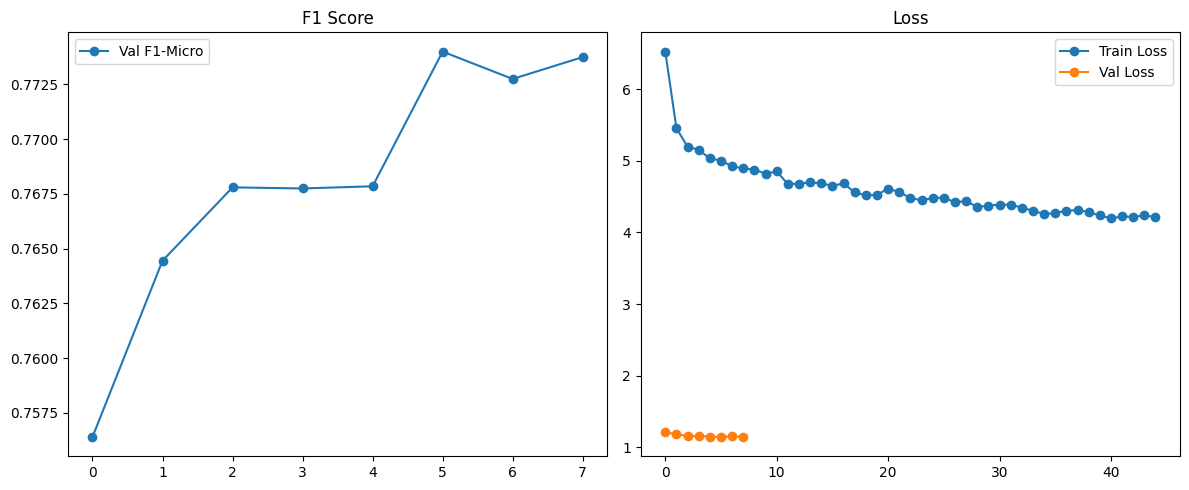

In [15]:
plt.figure(figsize =(12, 5))
plt.subplot(1, 2, 1)
plt.plot(vl_f1, label ='Val F1-Micro', marker ='o')
plt.title('F1 Score')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(tr_loss, label ='Train Loss', marker ='o')
plt.plot(vl_loss, label ='Val Loss', marker ='o')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('deberta_lora_learning_curve.png')
plt.show()

In [16]:
m_res =trn.evaluate()
print("--- PyTorch DeBERTa-v3 + LoRA F1-Micro ---")
print(m_res['eval_f1_micro'])

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


--- PyTorch DeBERTa-v3 + LoRA F1-Micro ---
0.774


<h2 style="direction:rtl; text-align:right; font-family:'Vazir', 'Tahoma', sans-serif; margin-top:15px; margin-bottom:10px;">تحلیل نهایی و تولید خروجی</h2>
<p style="direction:rtl; text-align:justify; font-family:'Vazir', 'Tahoma', sans-serif; margin-bottom:12px;">
مدل DeBERTa با ترکیب LoRA توانست به عدد خیره کننده 77.4 درصد در معیار F1-Micro دست یابد. نمودارهای یادگیری نشان می دهند که استراتژی های کنترل اورفیتینگ به خوبی عمل کرده و مدل به جای حفظ کردن داده ها، الگوهای زبانی را به درستی آموخته است. در نهایت، از همین وزن های بهینه شده برای پیش بینی لیبل های مجموعه آزمون استفاده کرده و با افزودن عدد 1 به خروجی ها، مقادیر را به استانداردِ 1 تا 5 ستاره بازگرداندیم تا در قالب فایل q2_submission.csv برای ارزیابی نهایی ذخیره گردد.
</p>


In [17]:
gdown.download("https://drive.google.com/uc?id=1-8TsrqTRFP-q9TM-6HinhO0ZVXFHq9TB", "test_data.csv", quiet =False)
df_test =pd.read_csv("test_data.csv", low_memory =False)


Downloading...
From: https://drive.google.com/uc?id=1-8TsrqTRFP-q9TM-6HinhO0ZVXFHq9TB
To: /kaggle/working/test_data.csv
100%|██████████| 15.6M/15.6M [00:00<00:00, 55.2MB/s]


In [18]:
df_test['summary'] =df_test['summary'].fillna("")
df_test['reviewText'] =df_test['reviewText'].fillna("")
df_test['full_txt'] =df_test['summary'] + " . " + df_test['reviewText']
df_test['clean_txt'] =df_test['full_txt'].apply(clean_txt)
test_ds =Dataset.from_dict({"text": df_test['clean_txt'].tolist()}).map(tok_func, batched =True)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [19]:
p_raw =trn.predict(test_ds)
p_cls =np.argmax(p_raw.predictions, axis =1) + 1

df_sub =pd.DataFrame({'predicted': p_cls})
df_sub.to_csv('q2_submission.csv', index =False)